In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random

random.seed(42)

big_dataset = pd.read_csv("feature_with_ALH_with_lat_lon.csv", index_col=0)

train_dataset, test_dataset = train_test_split(big_dataset, test_size=0.2, random_state=42)

X_train = train_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)
X_test = test_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)

y_train_calipso = (train_dataset["AOD_CALIPSO"])
y_test_calipso = (test_dataset["AOD_CALIPSO"])

sc = MinMaxScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

X_train

,O2_continum,weak_CO2_continum,strong_CO2_continum,OCO_zenith_angle,O2_mid_1,O2_mid_2,O2_mid_3,weak_CO2_mid_1,weak_CO2_mid_2,weak_CO2_mid_3,strong_CO2_mid_1,strong_CO2_mid_2,strong_CO2_mid_3
0,0.012530,0.075962,0.086886,0.615588,0.320651,0.754954,0.942213,0.944387,0.971198,0.978586,0.424899,0.530046,0.596183
1,0.185818,0.315340,0.157143,0.970583,0.806726,0.932153,0.979799,0.974497,0.960446,0.972265,0.887465,0.767493,0.795612
2,0.003054,0.011682,0.012888,0.969380,0.449693,0.790434,0.927631,0.823586,0.842318,0.846524,0.422571,0.561805,0.655045
3,0.033369,0.267459,0.347364,0.965254,0.531009,0.841910,0.930876,0.966710,0.983211,0.985975,0.704749,0.823961,0.883804
4,0.043303,0.257308,0.209602,0.633736,0.345492,0.797281,0.964038,0.939680,0.965083,0.973953,0.418617,0.570235,0.678885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30183,0.004816,0.022425,0.026989,0.438203,0.330762,0.755012,0.926763,0.896902,0.942147,0.961757,0.410098,0.562891,0.671208
30184,0.019151,0.039896,0.030377,0.307352,0.066222,0.583398,0.952314,0.881609,0.938783,0.961122,0.148722,0.281403,0.410310
30185,0.058671,0.287390,0.228414,0.156029,0.555202,0.837386,0.955571,0.963491,0.979779,0.986600,0.581112,0.665630,0.713046
30186,0.057923,0.291394,0.257238,0.806858,0.432975,0.783964,0.914304,0.965202,0.984624,0.989788,0.633731,0.721741,0.739997


In [4]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(13,)))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dense(units=64, activation='relu')),

model.add(tf.keras.layers.Dense(units=32, activation='relu')),

model.add(tf.keras.layers.Dense(units=16, activation='relu'))

model.add(tf.keras.layers.Dense(units=8, activation='relu'))

model.add(tf.keras.layers.Dense(units=4, activation='relu'))

model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(X_train, y_train_calipso, validation_split=.1,  epochs=1000)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,833 (50.13 KB)

 Trainable params: 12,833 (50.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 4.1667 - val_loss: 2.4964
Epoch 2/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - loss: 2.6057 - val_loss: 2.4603
Epoch 3/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - loss: 2.5799 - val_loss: 2.4179
Epoch 4/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step - loss: 2.5253 - val_loss: 2.3954
Epoch 5/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - loss: 2.5326 - val_loss: 2.4350
Epoch 6/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - loss: 2.5479 - val_loss: 2.3612
Epoch 7/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - loss: 2.4556 - val_loss: 2.3328
Epoch 8/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - loss: 2.4462 - val_loss: 2.3707
Epoch 9/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 2.4099 - val_loss: 2.2821
Epoch 10/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - loss: 2.3744 - val_loss: 2.2901
Epoch 11/1000
850/850 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - loss: 2.4106 - val_loss: 2.2486
Epoch 12

In [12]:
model.save("NN.keras")

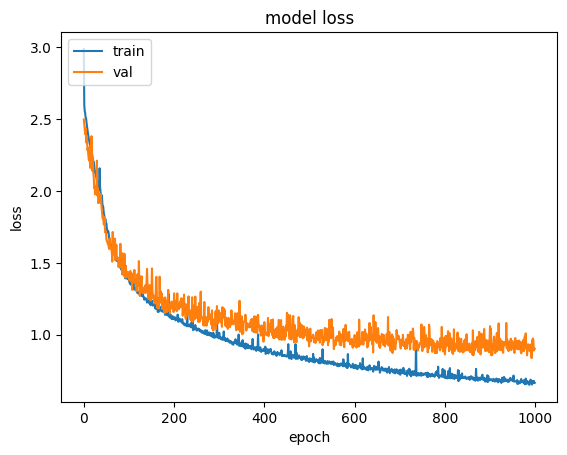

In [13]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [16]:
model = tf.keras.models.load_model("NN.keras")

In [17]:
pred = model.predict(X_test).flatten()
pred

236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


array([-2.754036 , -5.0695896, -5.547034 , ..., -5.031937 , -5.005485 ,
       -3.329524 ], dtype=float32)

In [18]:
print(pred.shape)
print(y_test_calipso.shape)

(7548,)
(7548,)


944/944 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


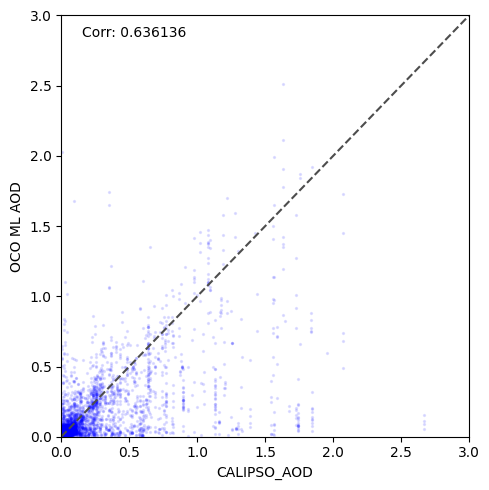

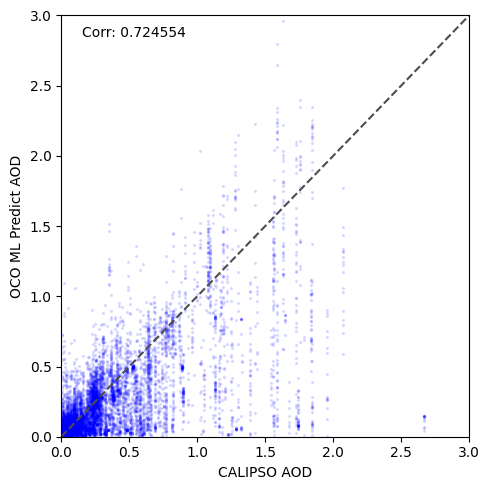

In [19]:
def plot_scatter(
    X,
    Y,
    dataset_name,
    feature_name,
    x_label=None,
    y_label=None,
    x_log=True,
    y_log=True,
):
    import matplotlib.pyplot as plt
    
    nan_mask = np.logical_or(np.isnan(X), np.isnan(Y))
    X = X[~nan_mask]
    Y = Y[~nan_mask]

    if x_log:
        X = np.exp(X)
    if y_log:
        Y = np.exp(Y)
    # print(Y.min(), Y.max())

    if x_label is None:
        x_label = f"CALIPSO {feature_name}"
    if y_label is None:
        y_label = f"OCO ML Predict {feature_name}"

    LIMIT = 3.0
    plt.figure(figsize=(5, 5))
    plt.scatter(X, Y, s=2, c="b", alpha=0.1)
    plt.plot([0, 10], [0, 10], ls="--", c=".3")
    # calc and plot correlation coefficient
    mask = np.logical_and(X > 0, Y > 0)
    corr = np.corrcoef(X[mask], Y[mask])[0, 1]
    plt.text(0.05, 0.95, f"Corr: {corr:.6f}", transform=plt.gca().transAxes)

    lim = min(LIMIT, max(X.max(), Y.max()))
    plt.xlim(0, min(LIMIT, lim))
    plt.ylim(0, min(LIMIT, lim))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.savefig(f"{dataset_name}_{feature_name}.png")

plot_scatter(y_test_calipso, pred, "CALIPSO", "AOD", x_label="CALIPSO_AOD", y_label="OCO ML AOD")

train_pred = model.predict(X_train).flatten()

plot_scatter(y_train_calipso, train_pred, "CALIPSO_train", "AOD")